# Preamble

In [1]:
import os
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

from intervaltree import Interval,IntervalTree

from time import time

import tensorflow as tf

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

%matplotlib inline

env: MUSICNET=/mnt/ssd/scratch/musicnet.npz


### Constants

In [2]:
d = 16384       # input dimensions
m = 128         # number of notes
fs = 44100      # samples/second
features = 0
labels = 1

restore_weights = True
folder = 'mlp_wide_log/'

musicnet = os.environ['MUSICNET']

### Load MusicNet

In [3]:
train_data = dict(np.load(open(musicnet,'rb')))

In [4]:
# split our the test set
test_data = dict()
for id in (2303,2382,1819): # test set
    test_data[str(id)] = train_data.pop(str(id))
    
train_ids = train_data.keys()
test_ids = test_data.keys()
    
print len(train_data)
print len(test_data)

327
3


### Create the test set

In [5]:
# create the test set
Xtest = np.empty([3*7500,d])
Ytest = np.zeros([3*7500,m])
for i in range(len(test_ids)):
    for j in range(7500):
        index = fs+j*512 # start from one second to give us some wiggle room for larger segments
        Xtest[7500*i + j] = test_data[test_ids[i]][features][index:index+d]
        Xtest[7500*i + j] /= np.linalg.norm(Xtest[7500*i + j]) + 10e-6
        
        # label stuff that's on in the center of the window
        for label in test_data[test_ids[i]][labels][index+d/2]:
            Ytest[7500*i + j,label.data[1]] = 1

# Raw MLP

In [6]:
tf.reset_default_graph()
tf.set_random_seed(999)

k = 500

x = tf.placeholder(tf.float32, shape=[None,d])
y_ = tf.placeholder(tf.float32, shape=[None, m])

scale = 10e-7

w = tf.Variable(scale*tf.random_normal([d,k],seed=999))
beta = tf.Variable(scale*tf.random_normal([k,m],seed=999))

zx = tf.log(tf.constant(1.) + tf.nn.relu(tf.matmul(x,w)))
y = tf.matmul(zx,beta)
L = tf.reduce_mean(tf.nn.l2_loss(y-y_))

init = tf.global_variables_initializer()

In [8]:
if restore_weights:
    weights = np.load(open(folder + 'w.npy','rb'))
    coefficients = np.load(open(folder + 'beta.npy','rb'))
    average_precision = list(np.load(open(folder + 'ap.npy','rb')))
    square_error = list(np.load(open(folder + 'loss.npy','rb')))
    weights_top = list(np.load(open(folder + 'wtop.npy','rb')))
    weights_bottom = list(np.load(open(folder + 'wbot.npy','rb')))

    sess = tf.Session()
    sess.run(w.assign(weights))
    sess.run(beta.assign(coefficients))
    init_lr = .001/2
else:
    square_error = []
    weights_top = []
    weights_bottom = []
    average_precision = []
    sess = tf.Session()
    sess.run(init)
    init_lr = .001

In [9]:
lr =  init_lr
opt = tf.train.GradientDescentOptimizer(lr)
train_step = opt.minimize(L)
Xmb = np.empty([len(train_data),d])
np.random.seed(998)
start = time()
print 'iter\tsquare_loss\tweights_top\tweights_bottom\tavg_precision\ttime'
for i in xrange(500000):
    if i % 100 == 0 and (i != 0 or len(square_error) == 0):
        square_error.append(sess.run(L, feed_dict={x: Xtest, y_: Ytest})/Xtest.shape[0])
        weights_top.append(np.mean(np.linalg.norm(beta.eval(session=sess),axis=0)))
        weights_bottom.append(np.mean(np.linalg.norm(w.eval(session=sess),axis=0)))
        
        Yhattestbase = sess.run(y,feed_dict={x: Xtest})
        yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
        yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])
        average_precision.append(average_precision_score(yflat, yhatflat))
        
        end = time()
        print i,'\t', round(square_error[-1],8),\
                '\t', round(weights_top[-1],8),\
                '\t', round(weights_bottom[-1],8),\
                '\t', round(average_precision[-1],8),\
                '\t', round(end-start,8)
        start = time()
    
    Ymb = np.zeros([len(train_data),m])
    for j in range(len(train_ids)):
        s = np.random.randint(d/2,len(train_data[train_ids[j]][features])-d/2)
        Xmb[j] = train_data[train_ids[j]][features][s-d/2:s+d/2]
        Xmb[j] /= np.linalg.norm(Xmb[j]) + 10e-6
        for label in train_data[train_ids[j]][labels][s]:
            Ymb[j,label.data[1]] = 1
    
    sess.run(train_step, feed_dict={x: Xmb, y_: Ymb})

iter	square_loss	weights_top	weights_bottom	avg_precision	time
100 	0.7306934 	1.51726317 	3.49189591 	0.60002319 	8.99467111
200 	0.73096441 	1.51730037 	3.49195576 	0.59983208 	8.49065804


KeyboardInterrupt: 

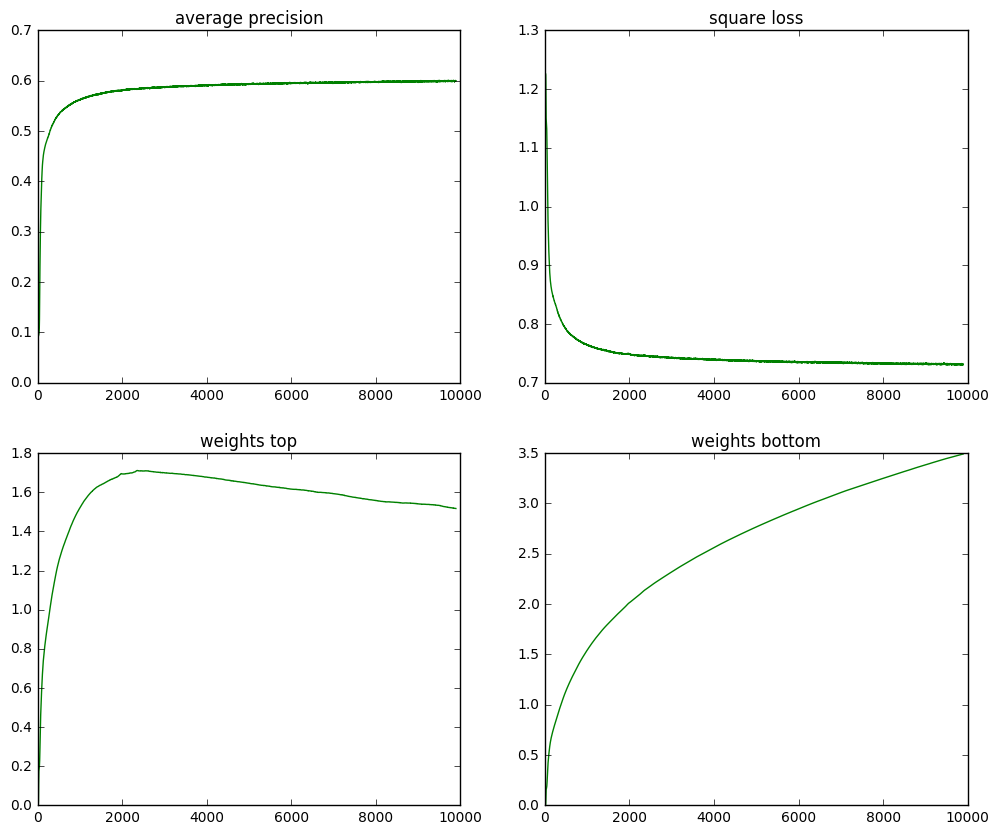

In [10]:
burnin=1
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(10)
ax1.set_title('average precision')
ax1.plot(average_precision[burnin:],color='g')
ax2.set_title('square loss')
ax2.plot(square_error[burnin:],color='g')
ax3.set_title('weights top')
ax3.plot(weights_top[burnin:],color='g')
ax4.set_title('weights bottom')
ax4.plot(weights_bottom[burnin:],color='g')

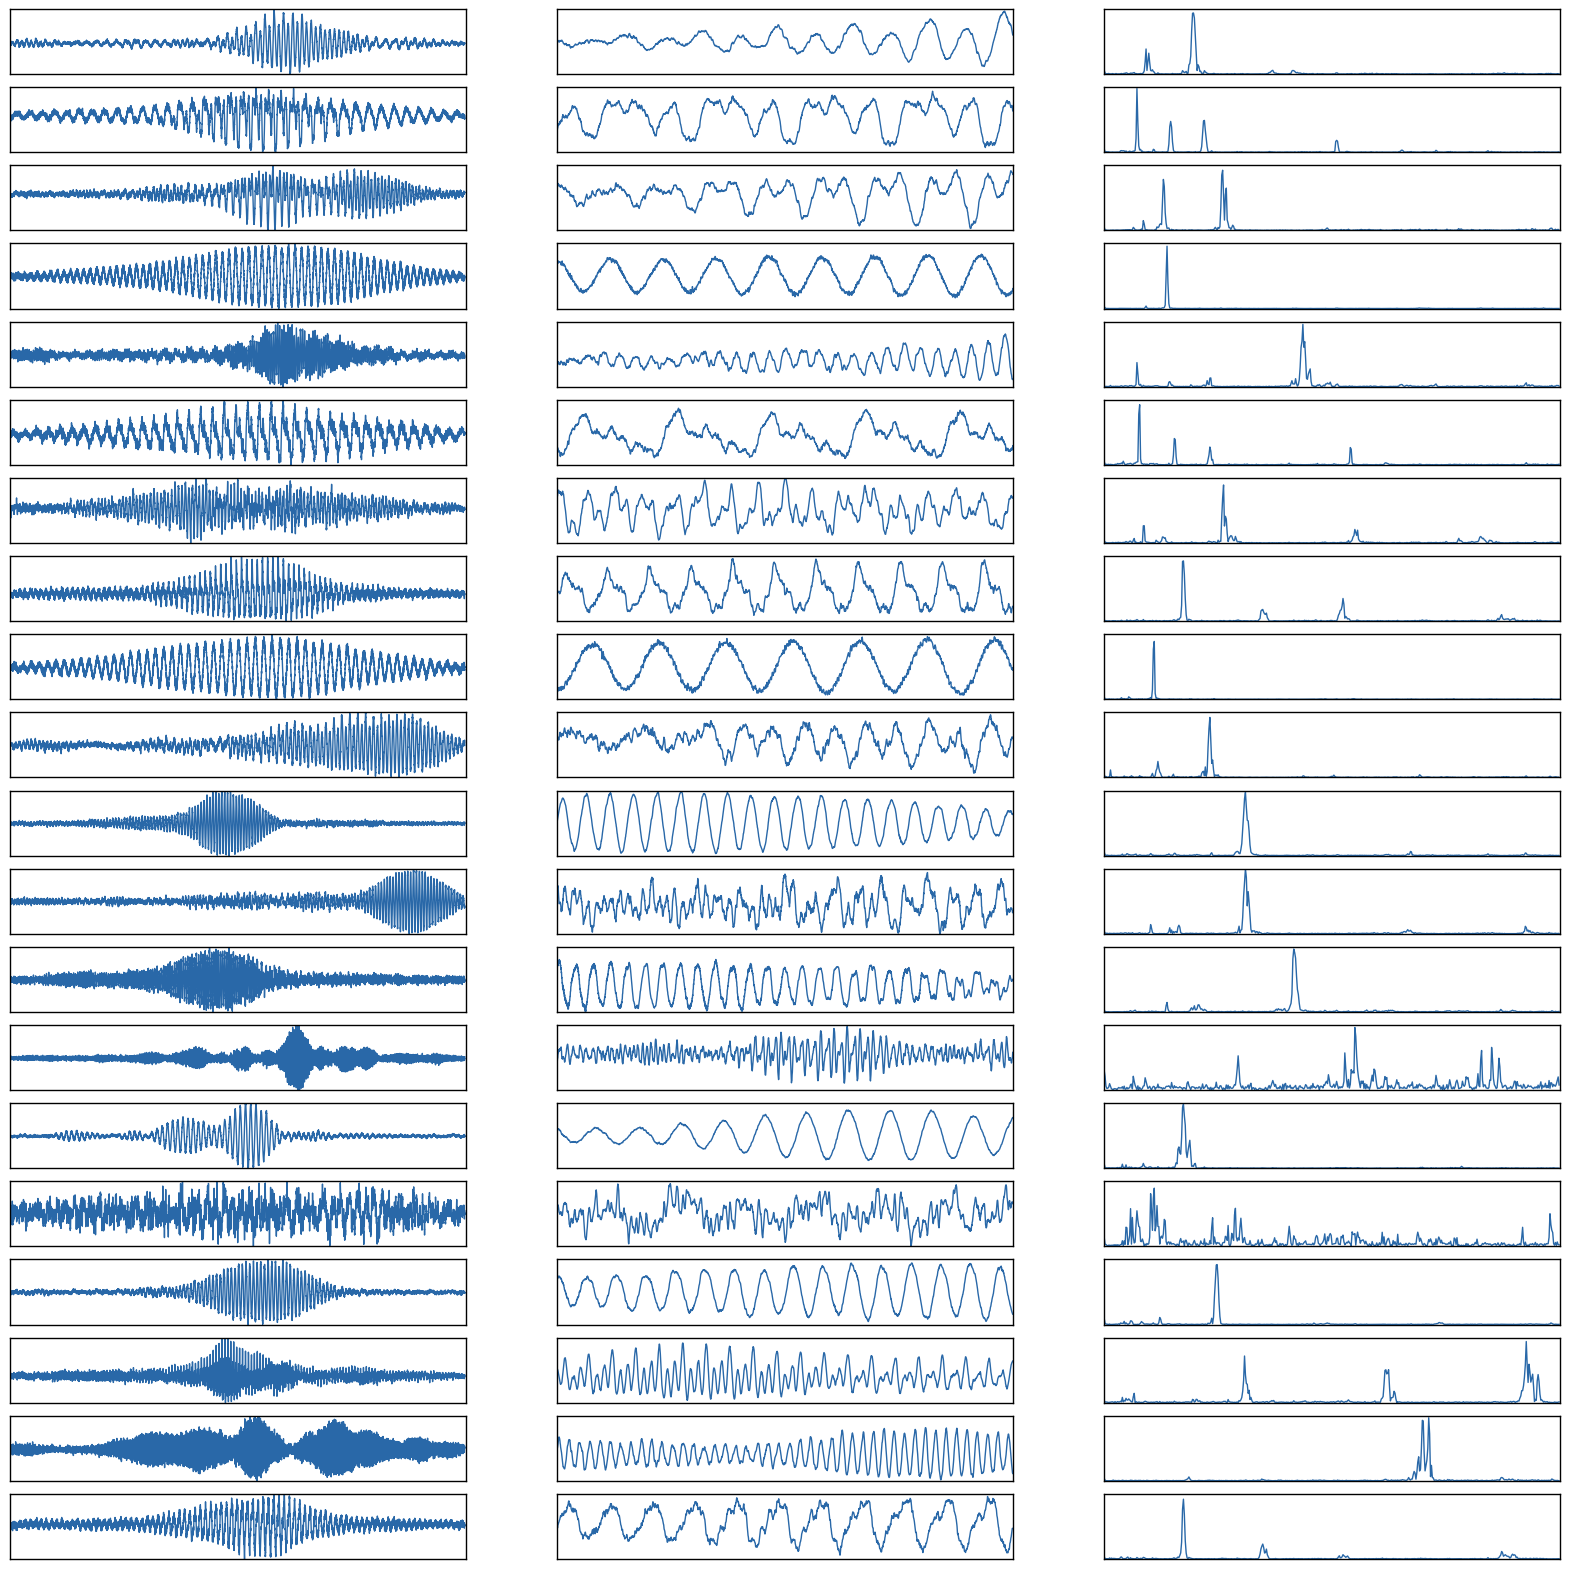

In [11]:
offset = 20
window = 2048
f, ax = plt.subplots(20,3, sharey=False)
f.set_figheight(20)
f.set_figwidth(20)
weights = w.eval(session=sess)
for i in range(20):
    ax[i,0].plot(weights[10:-10,i+offset], color=(41/255.,104/255.,168/255.))
    ax[i,0].set_xlim([-20,d+20])
    ax[i,0].set_ylim([np.min(weights[10:-10,i+offset]),np.max(weights[10:-10,i+offset])])
    ax[i,0].set_xticklabels([])
    ax[i,0].set_yticklabels([])
    ax[i,1].plot(weights[d/2-1024:d/2+1024,i+offset], color=(41/255.,104/255.,168/255.))
    ax[i,1].set_xticklabels([])
    ax[i,1].set_yticklabels([])
    ax[i,1].set_xlim([0,2048])
    ax[i,2].plot(np.abs(fft(weights[:,i+offset]))[0:500], color=(41/255.,104/255.,168/255.))
    ax[i,2].set_xticklabels([])
    ax[i,2].set_yticklabels([])
    
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

In [ ]:
folder = 'mlp_wide_log/'

weights = w.eval(session=sess)
coefficients = beta.eval(session=sess)

np.save(open(folder + 'w.npy','wb'),weights)
np.save(open(folder + 'beta.npy','wb'),coefficients)
np.save(open(folder + 'ap.npy','wb'),average_precision)
np.save(open(folder + 'loss.npy','wb'),square_error)
np.save(open(folder + 'wtop.npy','wb'),weights_top)

np.save(open(folder + 'wbot.npy','wb'),weights_bottom)

# Log-transform

In [ ]:
n = 1000              # training data points per recording

# sufficient statistics for least squares
XTX = np.zeros((k,k))
XTY = np.zeros((k,m))

# Warning: this could take some time
Xs = np.empty((n,k))
for recording in train_data:
    print recording, ',',
    X,Y = train_data[recording]
    s = np.random.randint(d/2,len(X)-d/2,n)
    Ys = np.zeros((n,m))
    for i in range(n):
        Xs[i] = sess.run(zx,feed_dict={x: X[s[i]-d/2:s[i]+d/2].reshape(1,d)})
        for label in Y[s[i]]:
            Ys[i,label.data[1]] = 1
    XTX += (1./n)*np.dot(Xs.T,Xs)
    XTY += (1./n)*np.dot(Xs.T,Ys)
XTX /= float(len(train_data))
XTY /= float(len(train_data))

In [ ]:
grid = [2**i for i in range(-20,-10)]
ap_ls = []
for r in grid:
    print r,', ',
    betals = np.linalg.solve(XTX + r*np.eye(XTX.shape[0]),XTY)
    
    Yhat = np.dot(sess.run(zx,feed_dict={x: Xtest}),betals)
    yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
    yhatflat = Yhat.reshape(Yhat.shape[0]*Yhat.shape[1])
    ap_ls.append(average_precision_score(yflat, yhatflat))
    
fig = plt.figure()
plt.plot(range(-20,-10),ap_ls,color=(41/255.,104/255.,168/255.),linewidth=3)
fig.axes[0].set_xlabel('regularizer (order of magnitude)')
fig.axes[0].set_ylabel('average precision')

# MIREX evaluation

In [ ]:
import mir_eval

In [ ]:
def estimate(X,subdiv=50):
    subset = X.shape[0]/subdiv
    Yhatbase = np.empty((X.shape[0],m))
    for j in range(subdiv):
        Yhatbase[subset*j:subset*(j+1)] = sess.run(y,feed_dict={x: X[subset*j:subset*(j+1)]})
        
    return Yhatbase

In [ ]:
Xvalidation = np.zeros([50*len(train_data),d])
Yvalidation = np.zeros([50*len(train_data),m])
for i in range(len(train_data)):
    # 50 random samples from each recording
    s = np.random.randint(d/2,len(train_data[train_ids[i]][features])-d/2,size=100)
    for j in range(50):
        Xvalidation[50*i+j] = train_data[train_ids[i]][features][s[j]-d/2:s[j]+d/2]
        Xvalidation[50*i+j] /= np.linalg.norm(Xvalidation[50*i+j]) + 10e-6
        # label stuff that's on in the center of the window
        for label in train_data[train_ids[i]][labels][s[j]]:
            Yvalidation[50*i+j,label.data[1]] = 1

In [ ]:
Yhatbase = estimate(Xvalidation)

# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalidation)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalidation)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

plt.plot(F)
i = np.argmax(F)
c = i/float(density)
print c

In [ ]:
Yhatbase = estimate(Xtest)

Yhat = Yhatbase>c
Yhatlist = []
Ytestlist = []
for i in range(len(Yhat)):
    fhat = []
    ftest = []
    for note in range(128):
        if Yhat[i][note] == 1:
            fhat.append(440.*2**((note - 69.)/12.))
        if Ytest[i][note] == 1:
            ftest.append(440.*2**((note - 69.)/12.))
    Yhatlist.append(np.array(fhat))
    Ytestlist.append(np.array(ftest))

In [ ]:
P,R,Acc,Esub,Emiss,Efa,Etot,cP,cR,cAcc,cEsub,cEmiss,cEfa,cEtot = \
mir_eval.multipitch.metrics(np.arange(len(Ytestlist))/100.,Ytestlist,np.arange(len(Yhatlist))/100.,Yhatlist)

print P
print R
print Acc
print Etot
print Esub
print Emiss
print Efa

print '-----'

print cP
print cR
print cAcc
print cEtot
print cEsub
print cEmiss
print cEfa

# Precision/Recall

In [ ]:
fs = 44100
m = 128

composition = 2
            
# create the test set
Xtest = np.empty([7500,d])
Ytest = np.zeros([7500,m])
for i in range(1):
    for j in range(7500):
        index = fs+j*512 # start from one second to give us some wiggle room for larger segments
        Xtest[j] = test_data[test_ids[composition]][features][index:index+d]
        Xtest[j] /= np.linalg.norm(Xtest[7500*i + j]) + 10e-6
        
        # label stuff that's on in the center of the window
        for label in test_data[test_ids[composition]][labels][index+d/2]:
            Ytest[7500*i + j,label.data[1]] = 1

In [ ]:
print test_ids[composition]

In [ ]:
Yhatbase = estimate(Xvalidation)

# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalidation)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalidation)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

plt.plot(F)
i = np.argmax(F)
c = i/float(density)
print c

In [ ]:
plt.plot(R,P)

In [ ]:
Yhattestbase = estimate(Xtest)
Yhat = Yhattestbase>c
true_positives = np.sum(Yhat*Ytest)
P = true_positives/(np.sum(Yhat))
R = true_positives/(np.sum(Ytest))
F = 2*(P*R)/(P+R)
print P
print R
print F

In [ ]:
yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])

precision, recall, _ = precision_recall_curve(yflat, yhatflat)
ap = average_precision_score(yflat, yhatflat)
plt.plot(recall,precision)
print ap

In [ ]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure()
plt.plot(recall,precision)
fig.axes[0].set_xlabel('recall')
fig.axes[0].set_ylabel('precision')

plt.tight_layout()
plt.savefig('gabor_pr.eps',format='eps', dpi=1000)